In [1693]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import StandardScaler

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import (RandomForestRegressor, 
                              AdaBoostRegressor, 
                              GradientBoostingRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [1694]:
data_raw = pd.read_csv('/Users/Janet/Desktop/EBAC/courses/semester 2/<CORE>DATA ANALYTICS/D4/totalBikeSharing_alex0820.csv')
data_raw.shape

(731, 49)

In [1695]:
# drop NA
data_raw = data_raw.dropna()
data_raw.shape

(723, 49)

In [1696]:
# column names
data_raw.columns

Index(['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'casual_lag2', 'regist_lag2', 'cnt_lag2',
       'cnt_inc_ratio', 'cnt_inc_ratio_lag2', 'cnt_inc_ratio_min_lastweek',
       'cnt_inc_ratio_max_lastweek', 'cnt_max', 'cnt_min', 'temp_inc',
       'casual_avg_ahead3days', 'regist_avg_ahead3days', 'cnt_avg_ahead3days',
       'casual_avg_aheadMonth', 'regist_avg_aheadMonth', 'cnt_avg_aheadMonth',
       'casual_median_LastWeek', 'regist_median_LastWeek',
       'cnt_median_LastWeek', 'casual_max_LastWeek', 'regist_max_LastWeek',
       'cnt_max_LastWeek', 'casual_inc_ratio_monthly',
       'regist_inc_ratio_monthly', 'cnt_inc_ratio_monthly',
       'casual_inc_ratio_weekly', 'regist_inc_ratio_weekly',
       'cnt_inc_ratio_weekly', 'casual_lastWeekday', 'regist_lastWeekday',
       'cnt_lastWeekday', 'casual_inc_ratio', 'regist_inc_ratio',
       'cnt_min_LastWeek'],


In [1669]:
# x = pd.DataFrame(data_raw.loc[:,(
#                                   'regist_avg_aheadMonth',
#                                  'workingday',
#                                  'weathersit',
#                                   'weekday',
#                                  'season',
#                                  'holiday',
#                                  'hum',
#                                  'windspeed',
#                                  'temp',
#                                  'regist_lag2',
#                                  'regist_avg_aheadWeek',
#                                  'regist_max_aheadWeek',
#                                   'regist_lastWeekday'
#                                  )])
# y = pd.DataFrame(data_raw.loc[:,('regist_inc_ratio')])

In [1670]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LinearRegression

# names = x.columns
# #use linear regression as the model
# lr = LinearRegression()
# #rank all features, i.e continue the elimination until the last one
# rfe = RFE(lr, n_features_to_select=1)
# rfe.fit(x,y)
 
# print("Features sorted by their rank:")
# print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))


In [1671]:
# from sklearn.linear_model import Ridge

# #Data gets scaled automatically by sklearn's implementation
# names = x.columns  
# ridge = Ridge(alpha=7)
# ridge.fit(x, y)
# print("Features sorted by their score:")
# print(sorted(zip(np.abs(ridge.coef_), names), reverse=True))

In [1672]:
# feature selection
index = pd.DataFrame(data_raw.loc[:,'dteday'])
x = pd.DataFrame(data_raw.loc[:,(
#                                  'regist_avg_aheadMonth',
                                 'workingday',
                                 'weathersit',
#                                  'weekday',
                                  'season',
#                                  'holiday',
#                                  'hum_inc',
#                                   'windspeed',
                                  'temp_inc',
#                                  'cnt_lag2',
#                                   'cnt_avg_aheadWeek',
#                                  'cnt_median_LastWeek',
#                                  'cnt_min_LastWeek',
                                  'cnt_inc_ratio_weekly',
                                  'cnt_inc_ratio_lag2',
#、                                  'cnt_inc_ratio_max_lastweek',
#                                  'cnt_inc_ratio_min_lastweek',
                                  'cnt_max',
                                  'cnt_min',
                                  'cnt_inc_ratio_monthly'
)])
y = pd.DataFrame(data_raw.loc[:,('cnt_inc_ratio','cnt','cnt_lag2')])
data = pd.concat([index,x,y], axis=1)

In [1673]:
# convert string to datetime
data.dteday = data.dteday.apply(lambda x:datetime.strptime(x, '%d/%m/%Y'))
# convert to object
data[['workingday','weathersit','season']] = data[['workingday','weathersit','season']].astype(str)

In [1674]:
data.dtypes

dteday                   datetime64[ns]
workingday                       object
weathersit                       object
season                           object
temp_inc                        float64
cnt_inc_ratio_weekly            float64
cnt_inc_ratio_lag2              float64
cnt_max                         float64
cnt_min                         float64
cnt_inc_ratio_monthly           float64
cnt_inc_ratio                   float64
cnt                               int64
cnt_lag2                        float64
dtype: object

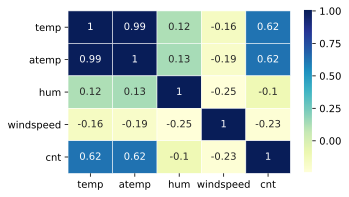

In [1700]:
# confusion matrix
x_numeric = data_raw.loc[:, ['temp','atemp','hum','windspeed','cnt' ]]
f, ax = plt.subplots(figsize = (5,3)) # f-figure, ax-axis
sns.heatmap(x_numeric.corr(),annot = True, linewidths = 0.5, ax = ax, cmap="YlGnBu")

In [1676]:
# # dummy code
# data = pd.get_dummies(data, dummy_na= True)
# data.head(5)

In [1677]:
# split training and test
train = data[data.dteday < datetime(2012, 1, 1)]
test = data[data.dteday > datetime(2011, 12, 31)]
test = test.reset_index(drop=True)

x_train = train.drop(['cnt_inc_ratio','cnt','dteday','cnt_lag2'],axis = 1)
x_test = test.drop(['cnt_inc_ratio','cnt','dteday','cnt_lag2'],axis = 1)

x_train_regist = train.drop(['cnt_inc_ratio','cnt','dteday','cnt_lag2'],axis = 1)
y_train_regist = pd.DataFrame(train.loc[:,'cnt_inc_ratio'])
# x_train_casual = train.loc[:,('season','mnth','workingday','weathersit','temp','casual_lag2','casual_avg_aheadWeek')]
# y_train_casual = pd.DataFrame(train.loc[:,'casual_inc_ratio'])


x_test_regist = test.drop(['cnt_inc_ratio','cnt','dteday','cnt_lag2'],axis = 1)
y_test_regist = pd.DataFrame(test.loc[:,'cnt_inc_ratio'])
# # x_test_casual = test.loc[:,('season','mnth','workingday','weathersit','temp','casual_lag2','casual_avg_aheadWeek')]
# # y_test_casual = pd.DataFrame(test.loc[:,'regist_inc_ratio'])

In [1678]:
# standardization
numeric = x_train_regist.dtypes[x_train_regist.dtypes == 'float64'].index

scaler = StandardScaler().fit(x_train_regist[numeric])
x_train_regist[numeric] = scaler.transform(x_train_regist[numeric])
x_test_regist[numeric] = scaler.transform(x_test_regist[numeric])

In [1679]:
ntrain = x_train.shape[0] #shape(n,m), n rows, m columns; shape[0] row number; shape[1] column number
ntest = x_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
#        self.clf = clf()
        params['random_state'] = seed
        self.clf = clf(**params)
    
#    def train(self, x_train, y_train_registered):
#        self.clf.fit(x_train, y_train_registered)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
    def get_params(self):
        return self.clf.get_params()
        

In [1680]:
# # create a function that can use with different models
# def classification_model(model, prediction_input, output):
#     # the whole process is implemented on training dataset
#     # 用所有traing dataset训练模型看准确率和cv有没很大差异
#     model.fit(prediction_input,output)
#     predictions = model.predict(prediction_input)
#     rmse = np.sqrt(mean_squared_error(predictions,output))
#     print("RMSE : %s" % "{0:.3%}".format(rmse))
    
#     kf = KFold(prediction_input.shape[0], n_folds=5)
#     error = []
#     for train, test in kf:
#         train_X = (prediction_input.iloc[train,:])
#         train_y = output.iloc[train]
#         model.fit(train_X, train_y)
#         test_X=prediction_input.iloc[test,:]
#         test_y=output.iloc[test]
#         error.append(model.score(test_X,test_y))
#         error.append(np.sqrt(mean_squared_error(test)))
#         print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

In [1681]:
# grid search for parameter selection
def Regression_model_gridsearchCV(model, param_grid, x_train, y_train):
    clf = GridSearchCV(model, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
    clf.fit(x_train, y_train)
    print('The best parameter found on development set is:')
    print(clf.best_params_)
    print('the best estimator is')
    print(clf.best_score_)

In [1682]:
from pprint import pprint
pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [1683]:
# # randomforest
# model = RandomForestRegressor()

# param_grid = { 
#     'n_estimators': [100,200,300],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [5,10,15],
# #    'criterion' :['gini', 'entropy']
# #     'bootstrap': [True,False]
    
# }
# Regression_model_gridsearchCV(model,param_grid, x_train_regist, y_train_regist )

In [1684]:
# # randomforest parameters
rf_params = {
    'n_estimators': 100,
    'max_features': 'log2',
    'max_depth' : 10,
#    'criterion' :['gini', 'entropy']
#    'bootstrap': True
}

In [1685]:
# basic models
# dt = SklearnHelper(clf = DecisionTreeRegressor, seed = SEED)
rf = SklearnHelper(clf = RandomForestRegressor, seed = SEED, params = rf_params)
# svm = SklearnHelper(clf = SVC, seed=SEED)
# gb = SklearnHelper(clf = GradientBoostingRegressor, seed=SEED)
# ada = SklearnHelper(clf = AdaBoostRegressor, seed=SEED)

Random Forest RMSE is:  0.37779316696564763


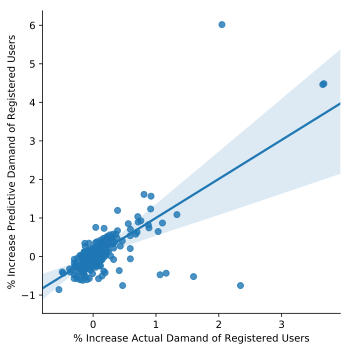

In [1686]:
# random forest
pre_regist_rf_ratio = pd.DataFrame(rf.fit(x_train_regist, y_train_regist).predict(x_test_regist))
rmse = np.sqrt(mean_squared_error(y_test_regist,pre_regist_rf_ratio))
print('Random Forest RMSE is: ', rmse)
pre_regist_rf_ratio.rename(columns = {pre_regist_rf_ratio.columns[0]:'pre_regist_rf_ratio'}, inplace=True)
test = pd.concat([pre_regist_rf_ratio, test], axis = 1)
g = sns.lmplot(x='pre_regist_rf_ratio', y='cnt_inc_ratio', data=test)
g.set_axis_labels("% Increase Actual Damand of Registered Users", "% Increase Predictive Damand of Registered Users")

Random Forest RMSE is:  1064.1611508240103


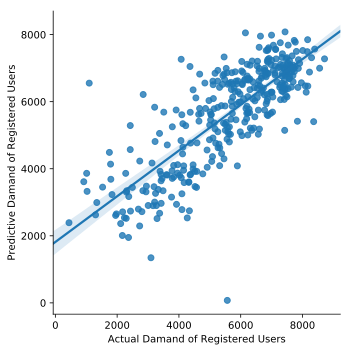

In [1687]:
# transform ratio back to absolute demand
test = test.assign(pre_regist_rf = (1+test.pre_regist_rf_ratio) * test.cnt_lag2)
rmse = np.sqrt(mean_squared_error(test.cnt,test.pre_regist_rf))
print('Random Forest RMSE is: ', rmse)

g = sns.lmplot(x='cnt', y='pre_regist_rf', data=test)
#g.set_titles("Demand of Registered Users")
g.set_axis_labels("Actual Damand of Registered Users", "Predictive Damand of Registered Users")

# for test.registered >= test.pre_regist_rf:
#     revenue = 3*test.pre_regist_rf
# for test.registered < test.pre_regist_rf:
#     revenue = 3*test.registered
# revenue = 3*test.registered
# cost = 2*test.pre_regist_rf
# profit = revenue - cost
# benchmark = 3*test.regist_lag2 - cost
# print('Profit of 2012:', profit.sum())
# print('Benchmark:', benchmark.sum())
# print('Improvement vs Benchmark', profit.sum() - benchmark.sum())

In [1688]:
# revenue 
revenue_bm = []
for i in range(0,test.cnt.shape[0]):
    if test.cnt[i] > test.cnt_lag2[i]:
        revenue_bm.append(test.cnt_lag2[i]*3)
    else:
        revenue_bm.append(test.cnt[i]*3)
revenue_bm = sum(revenue_bm)
cost_bm = sum(2*test.cnt_lag2)
profit_bm = revenue_bm - cost_bm



revenue = []
for i in range(0,test.cnt.shape[0]):
    if test.cnt[i] > test.pre_regist_rf[i]:
        revenue.append(test.pre_regist_rf[i]*3)
    else:
        revenue.append(test.cnt[i]*3)
revenue = sum(revenue)
cost = sum(2*test.pre_regist_rf)
profit = revenue - cost
print('Predictive Profit of 2012:', profit)
print('Benchmark Profit of 2012:', profit_bm)
print('Improvement:', profit-profit_bm)




Predictive Profit of 2012: 1610047.45205078
Benchmark Profit of 2012: 1456283.0
Improvement: 153764.45205077995


In [1689]:
# RevenuePerBike = 3
# LoanCostPerBike = 2
# Profit = pd.concat([test.registered, test.pre_regist_rf], axis = 1)
# Profit['revenue_daily'] = Profit.apply(lambda x: RevenuePerBike * min(x['registered'], x['pre_regist_rf']), axis = 1)
# Profit['cost_daily'] = Profit.apply(lambda x: LoanCostPerBike * x['pre_regist_rf'], axis = 1)


In [1690]:
# def revenue(act, pre):
#     revenue = []
#     for i in range(0,act.shape[0]):
#         if act[i] > pre[i]:
#             revenue.append(pre[i]*3)
#         else:
#             revenue.append(act[i]*3)
#     return sum(revenue)

# revenue(test.registered,test.pre_regist_rf)

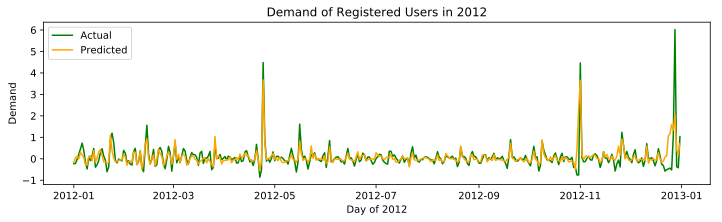

In [1691]:
# plot by time

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(12,3))

plt.plot(test.dteday, test.cnt_inc_ratio, color='g', label = 'Actual')
plt.plot(test.dteday, test.pre_regist_rf_ratio, color='orange',label ='Predicted')
plt.xlabel('Day of 2012')
plt.ylabel('Demand')
plt.title('Demand of Registered Users in 2012')
plt.legend(loc='best')
#plt.legend(test.registered ='Predicted',test.pre_regist_rf='Actual')
plt.show()

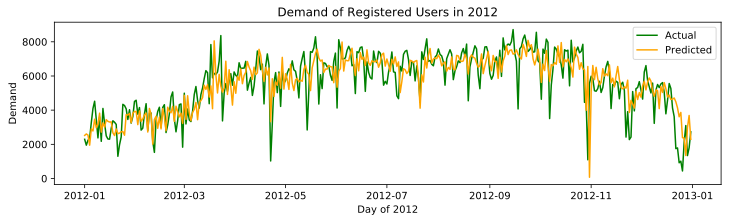

In [1692]:
# plot by time

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(12,3))

plt.plot(test.dteday, test.cnt, color='g', label = 'Actual')
plt.plot(test.dteday, test.pre_regist_rf, color='orange',label ='Predicted')
plt.xlabel('Day of 2012')
plt.ylabel('Demand')
plt.title('Demand of Registered Users in 2012')
plt.legend(loc='best')
#plt.legend(test.registered ='Predicted',test.pre_regist_rf='Actual')
plt.show()

In [624]:
test.to_csv('/Users/Janet/Desktop/test0822_cnt1.csv', index = False)